**Here we try crossing statistics with simulated light curves using Alex's method. For simplicity we first consider 2 images only. Also I changed some parameters in the light curve simulation.Here we have set: nobs=60, fluc=2, t1=60, which are slightly different from what Alex set.** 


In [1]:
%reset -f

In [1]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
#plt.rcParams['figure.figsize'] = [12, 8]

No. of data points in r,g,i,z bands= 60 60 60 60 respectively

Since we know the underlying model, we can calculate the Chi^2 in this simulation for the actual model. This might be handy later.

Chi^2 original: r-band= 55.72482627583692 g-band= 55.26918090366003 i-band= 60.53057740887345 z-band= 52.57550853103355


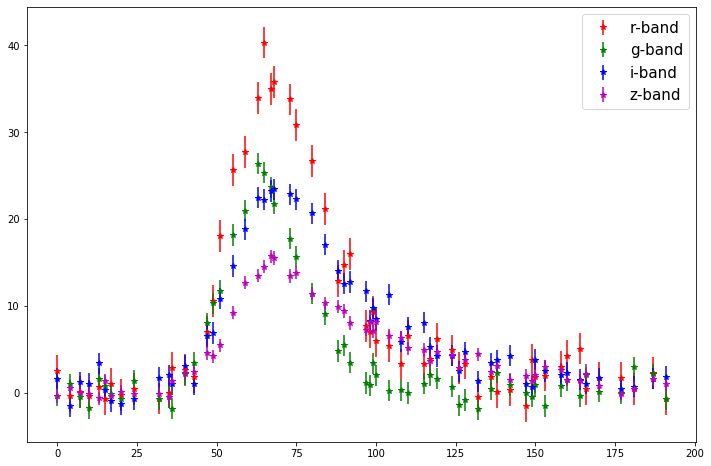

In [2]:
inp_path='Alex_simulated_data/'
bands=['lsstg','lsstr','lssti','lsstz']
fileN='Alex_sim_nobs_60_fluc2_t1_60_mu_1.8_3.0_dt_1.1_13.2'

fileNr=inp_path+fileN+bands[1]+'.txt';#print(fileNr)
fileNg=inp_path+fileN+bands[0]+'.txt';#print(fileNg)
fileNi=inp_path+fileN+bands[2]+'.txt';#print(fileNi)
fileNz=inp_path+fileN+bands[3]+'.txt';#print(fileNz)

tr,fr,sigfr,fr1,fr2=np.loadtxt(fileNr,usecols=[0,1,2,3,4], unpack=True)
tg,fg,sigfg,fg1,fg2=np.loadtxt(fileNg,usecols=[0,1,2,3,4], unpack=True)
ti,fi,sigfi,fi1,fi2=np.loadtxt(fileNi,usecols=[0,1,2,3,4], unpack=True)
tz,fz,sigfz,fz1,fz2=np.loadtxt(fileNz,usecols=[0,1,2,3,4], unpack=True)

print("No. of data points in r,g,i,z bands=",len(tr), len(tz),len(ti),len(tz),"respectively\n")

t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti), np.amin(tz)])
t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti), np.amax(tz)])
t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs)+1e-5;

#we substract a fixed time, it should not have any effect on the pystan results
tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; tz=tz-t_min;

t_max=t_max-t_min; t_min=0.0;

clr=['r','g','b','k']
plt.rcParams['figure.figsize'] = [12, 8]
plt.errorbar(tr,fr,yerr=sigfr,fmt="r*",label=r"r-band")
plt.errorbar(tg,fg,yerr=sigfg,fmt="g*",label=r"g-band")
plt.errorbar(ti,fi,yerr=sigfi,fmt="b*",label=r"i-band")
plt.errorbar(tz,fz,yerr=sigfz,fmt="m*",label=r"z-band")
plt.legend(loc=0,fontsize=15)


fro=fr1+fr2;fgo=fg1+fg2;fio=fi1+fi2;fzo=fz1+fz2
chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
print("Since we know the underlying model, we can calculate the Chi^2 in this simulation for the actual model. This might be handy later.")
print("\nChi^2 original: r-band=",chisqro,"g-band=",chisqgo,"i-band=",chisqio,"z-band=",chisqzo)


The system has two images: $\mu=1.8,3.0$ and $dt=1.1,13.2$. SInce below we mainly model the earlier image with the intrinsic flux model, we expect to find $\mu=3.0/1.8=1.667$ and $dt=13.2-1.1=12.1$.

In [3]:
mu_des=3.0/1.8; dt_des=12.1;

In [4]:
#template 2: t^n exp(-t/tk); stretch, crossing statistics upto 2nd order

#tmax=np.amax(tr)



def mod2(x,t0,n,xk,s,c0,c1,c2,c3,c4):
    x=x-t0;
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(x**n)*np.exp(-x/xk)
    xmax=np.amax(x)
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('nr', 2.0, True, 1.0,4.0), ('tkr', 10.0, True, 1.0,40.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('ng', 2.0, True, 1.0,4.0), ('tkg', 10.0, True, 1.0,40.0),('sg', 0.01,True, 0.0,0.99))#, ;

p.add_many(('mu1', 0.58, True, 0.4,2.0),('dt1',1.0, True,0,30.0) ,('t0',10.0, True,0.0,60.0));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0, False, -10,10) ,('c4r', 0.0,False, None,None))

p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0, False, -10,10) ,('c4g', 0.0,False, None,None))

p.add_many(('nni', 2.0, True, 1.0,4.0), ('tki', 10.0, True, 1.0,40.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0, False, -10,10))

p.add_many(('nz', 2.0, True, 1.0,4.0), ('tkz', 10.0, True, 1.0,40.0),('sz', 0.01,True, 0.0,0.99));
p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod2(tr,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod2(tr-v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod2(tg,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod2(tg-v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfg;
    
    B3=(mod2(ti,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],0,0)
            +v['mu1']*mod2(ti-v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],0,0)-fi)/sigfi;
    
    B4=(mod2(tz,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],0,0)
            +v['mu1']*mod2(tz-v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],0,0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3,B4))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res2 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=10000, steps=150000, thin=3, nwalkers=150,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res2.params)

100%|██████████| 150000/150000 [2:07:18<00:00, 19.64it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 28 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 3000;
tau: [12698.41968773 16368.45510026 18095.10044861 15493.92544975
 12865.3004868  13945.71343024 12235.75649837  5847.94500855
  5764.86562384 17950.01983433 18086.44853638 18028.440817
 14525.12742575 16169.7884416  14701.71732927 12559.7762709
 15572.35058431 16630.07599125 16742.84307352 17119.59268259
 16241.13740445 15442.35172775 15052.79048773 16264.26025477
 17349.22480838 16934.43893991 16316.92797758  6331.23496372]
[[Variables]]
    nr:         1.72577790 +/- 0.20390050 (11.81%) (init = 2)
    tkr:        9.12934283 +/- 2.81270019 (30.81%) (init = 10)
    sr:         0.35631411 +/- 0.21215504 (59.54%) (init = 0.01)
    ng:         1.82874192 +/- 0.27533331 (15.06%) (init = 2)
    tkg:        6.12703747 +/- 1.29827696 (21.19%) (init = 10)
    sg:         0.17856431 +/- 0.15828999 (88.65%) (init = 0.01)
    mu1:        

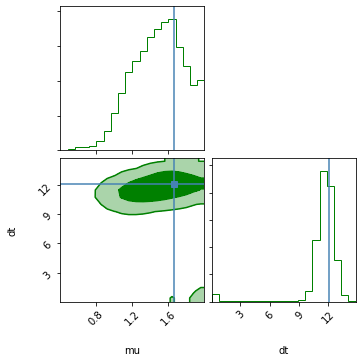

In [18]:
import corner
#print(res2.params.valuesdict().values())
emcee_plot = corner.corner(res2.flatchain[['mu1','dt1']], labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0,
                           truths=list([mu_des,dt_des]))

Now we see template 2 works good!


Maximum likelihood Estimation
-----------------------------


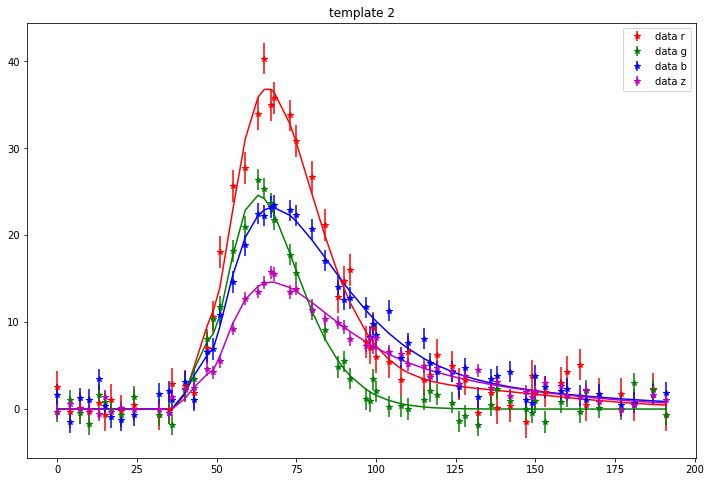

Maximum liklihood: mu= 1.8744986098701493 dt= 12.28766021540482
Chi^2 r= 65.24654918799988 Chi^2 g= 54.69135868030609 Chi^2 i= 66.52276395997322 Chi^2 z= 43.516058385165714
Chi^2 original: r= 55.72482627583692 g= 55.26918090366003 Chi^2 i= 60.53057740887345 Chi^2 z= 52.57550853103355


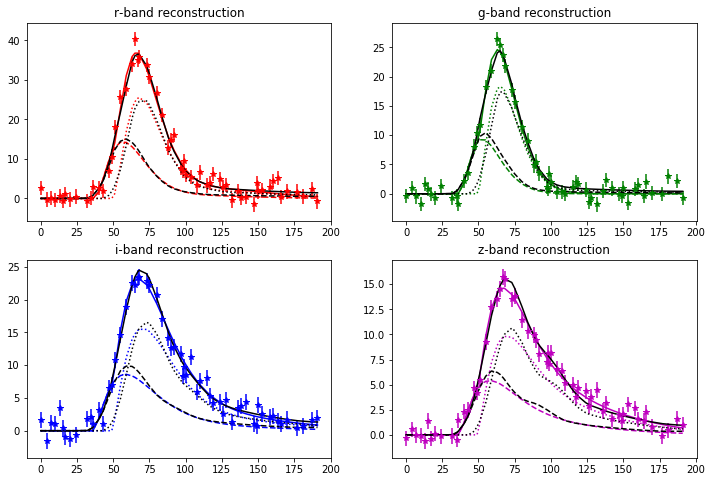

In [94]:
def plot_func2(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    c4rm=0; srm=0; c3rm=0;#mum=1.5;
    c4gm=0; sgm=0; c3gm=0;
    c2rm=c2gm=c2im=c2zm=0;
    [nrm,tkrm,srm,ngm,tkgm,sgm,mum,dtm,t0m,c0rm,c1rm,c2rm,c0gm,c1gm,c2gm,
     nim,tkim,sim,c0im,c1im,c2im,nzm,tkzm,szm,c0zm,c1zm,c2zm,lnm]=mle_soln;
    #print(nrm,tkrm,ngm,tkgm,mum,dtm,t0m,c0rm,c1rm,c0gm,c1gm,c2gm,lnm)
    #mum,dtm=1.4/2.4,15.0
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod2(tr,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Ps2r=mum*mod2(tr-dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Psr=Ps1r+Ps2r
    fro=fr1+fr2
    
    Ps1g=mod2(tg,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Ps2g=mum*mod2(tg-dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Psg=Ps1g+Ps2g
    fgo=fg1+fg2
    
    Ps1i=mod2(ti,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Ps2i=mum*mod2(ti-dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Psi=Ps1i+Ps2i
    fio=fi1+fi2
    
    Ps1z=mod2(tz,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Ps2z=mum*mod2(tz-dtm,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Psz=Ps1z+Ps2z
    fzo=fz1+fz2
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 2')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    #plt.plot(tr, Ps1r, c="r",ls="--")
    #plt.plot(tr, Ps2r, c="r",ls="dotted")
    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b") #data
    plt.plot(ti, Psi, c="b")
    
    plt.errorbar(tz,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(tz, Psz, c="m")
 
    plt.legend(loc=0)
    plt.show()
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2); chisqz=np.sum((Psz-fz)**2/sigfz**2);
    
    chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
    chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
    #chisq_o=np.sum((ft_total-y)**2/sigft**2)
    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("Chi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi,"Chi^2 z=",chisqz)
    print("Chi^2 original: r=",chisqro,"g=",chisqgo,"Chi^2 i=",chisqio,"Chi^2 z=",chisqzo)
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")
    plt.plot(tr, fro, c="k")
    plt.plot(tr, fr1,c="k",ls="--")
    plt.plot(tr, fr2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    
    plt.plot(tg, fgo, c="k")
    plt.plot(tg, fg1,c="k",ls="--")
    plt.plot(tg, fg2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")
    
    plt.plot(t, fio, c="k")
    plt.plot(t, fi1,c="k",ls="--")
    plt.plot(t, fi2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 4)
    plt.title(r'z-band reconstruction')
    t=tz
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(t,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(t, Psz, c="m")
    plt.plot(t, Ps1z,c="m",ls="--")
    plt.plot(t, Ps2z,c="m",ls="dotted")
    
    plt.plot(t, fzo, c="k")
    plt.plot(t, fz1,c="k",ls="--")
    plt.plot(t, fz2,c="k",ls="dotted")
    
    plt.show()
    
plot_func2(res2)

After observing some more cases, I believe the model $t^2 \exp(-t/t_k)$, even together with crossing statistics, can not describe the light curve of any particular image. That is why, probably, we are getting excellent fit to the combined light curves but the individual image lc's are not correctly recovered. 

In [7]:
def mod(x,t0,n,xk,s,c0,c1,c2,c3,c4):    
    mean=n;sig=xk;
    x=x-t0;
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    xmax=np.amax(x)
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mu1', 1.0, True, 0.4,2.0),('dt1',5.0, True,0,25.0) ,('t0',1.0, True,0.0,60.0));

p.add_many(('nr', 1.0, True, 0.1,10.0), ('tkr', 0.1, True, 0.0,3.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0.0, False, None,None) ,('c4r', 0.0,False, None,None))

p.add_many(('ng', 1.0, True, 0.1,10.0), ('tkg', 0.1, True, 0.0,3.0),('sg', 0.01,True, 0.0,0.99))#, ;
p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0.0,False, None,None) ,('c4g', 0.0,False, None,None))

p.add_many(('nni', 1.0, True, 0.0,10.0), ('tki', 0.1, True, 0.0,3.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0, False, None,None))

p.add_many(('nz', 1.0, True, 0.1,10.0), ('tkz', 0.10, True, 0.0,3.0),('sz', 0.01,True, 0.0,0.99));
p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None),
          ('c3z', 0, False, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod(tr,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod(tr-v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod(tg,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod(tg-v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfr;
    
    B3=(mod(ti,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],0)
            +v['mu1']*mod(ti-v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],0)-fi)/sigfi;
    
    B4=(mod(tz,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)
            +v['mu1']*mod(tz-v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3,B4))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=10000, steps=200000, thin=3, nwalkers=200,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res.params)

100%|██████████| 200000/200000 [3:30:34<00:00, 15.83it/s]  


The chain is shorter than 50 times the integrated autocorrelation time for 28 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4000;
tau: [15705.51935498  9751.47149818  8495.62207212  8081.96750066
  8480.8179787  14765.37446477 24056.63743077 24319.87973964
 23713.14011364 11704.7489543  12967.2582884  14717.60206021
 18739.78298428 17013.09061206 18142.44826769 16978.77495267
 12301.17839492 15100.39308472 21291.82164429 21313.17880215
 20352.55382076 12111.97582322 16303.50420044 13833.28323116
 21214.84454882 21250.25239218 21117.92537017 13410.99290144]
[[Variables]]
    mu1:        1.17766466 +/- 0.33441671 (28.40%) (init = 1)
    dt1:        11.9181173 +/- 0.89000749 (7.47%) (init = 5)
    t0:         33.7836319 +/- 4.06053651 (12.02%) (init = 1)
    nr:         3.35501693 +/- 0.45627163 (13.60%) (init = 1)
    tkr:        0.51026540 +/- 0.07789334 (15.27%) (init = 0.1)
    sr:         0.22271784 +/- 0.23146926 (103.93%) (init = 0.01)
    c0r:        

(12666600, 2)


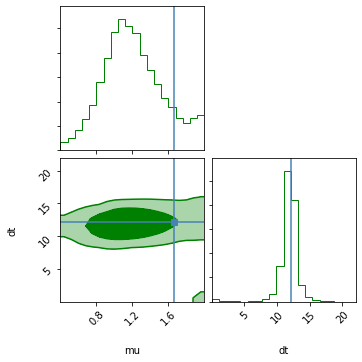

In [93]:
import corner 
res01=(res.flatchain[['mu1','dt1']])#[60000:]
print(res01.shape)
emcee_plot = corner.corner(res01, labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0,
                           truths=list([mu_des,dt_des]))


Maximum likelihood Estimation
-----------------------------


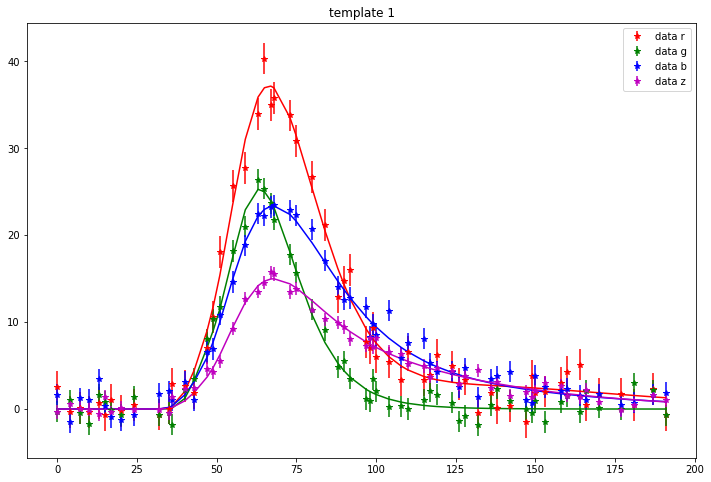

Maximum liklihood: mu= 1.8768745752692266 dt= 11.29221008180094

Chi^2 r= 57.741355433597214 Chi^2 g= 53.31542021105915 Chi^2 i= 59.92392940709372 Chi^2 z= 45.579496932096525
Chi^2 original: r= 55.72482627583692 g= 55.26918090366003 Chi^2 i= 60.53057740887345 Chi^2 z= 52.57550853103355


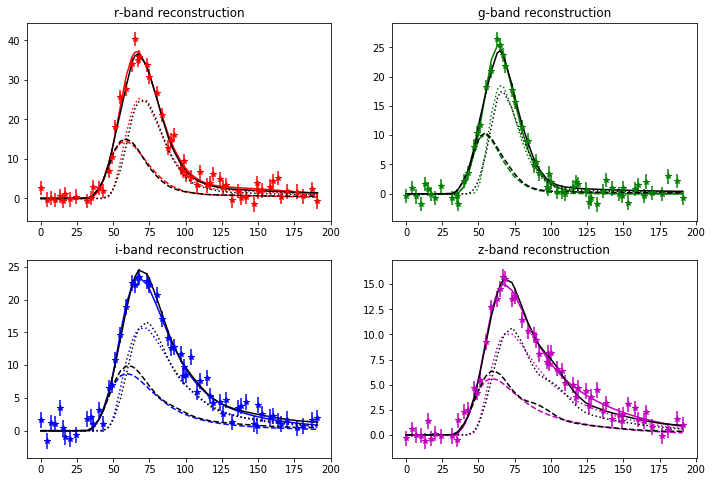

In [9]:
def plot_func(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    #print(len(mle_soln))
    c4rm=0; srm=0; c3rm=0;#mum=1.5;
    c4gm=0; sgm=0; c3gm=0;
    c2rm=c2gm=c2im=c2zm=0;
    [mum,dtm,t0m,
     nrm,tkrm,srm,c0rm,c1rm,c2rm,#c3rm,
     ngm,tkgm,sgm,c0gm,c1gm,c2gm,#c3gm,
     nim,tkim,sim,c0im,c1im,c2im,
     nzm,tkzm,szm,c0zm,c1zm,c2zm,
     lnm]=mle_soln;
    
    #print(mle_soln)
    #print("g-band: ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm=",ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm)
    #mum,dtm=1.4/2.4,15.0
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod(tr,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,0)
    Ps2r=mum*mod(tr-dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,0)
    Psr=Ps1r+Ps2r
    fro=fr1+fr2
    
    Ps1g=mod(tg,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,0)
    Ps2g=mum*mod(tg-dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,0)
    Psg=Ps1g+Ps2g
    fgo=fg1+fg2
    
    Ps1i=mod(ti,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Ps2i=mum*mod(ti-dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Psi=Ps1i+Ps2i
    fio=fi1+fi2
    
    Ps1z=mod(tz,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Ps2z=mum*mod(tz-dtm,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Psz=Ps1z+Ps2z
    fzo=fz1+fz2
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 1')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    #plt.plot(tr, Ps1r, c="r",ls="--")
    #plt.plot(tr, Ps2r, c="r",ls="dotted")
    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b") #data
    plt.plot(ti, Psi, c="b")
    
    plt.errorbar(tz,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(tz, Psz, c="m")
 
    plt.legend(loc=0)
    plt.show()
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2); chisqz=np.sum((Psz-fz)**2/sigfz**2);
    c4gm
    chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
    chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
    #chisq_o=np.sum((ft_total-y)**2/sigft**2)
    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("\nChi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi,"Chi^2 z=",chisqz)
    print("Chi^2 original: r=",chisqro,"g=",chisqgo,"Chi^2 i=",chisqio,"Chi^2 z=",chisqzo)
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")
    plt.plot(tr, fro, c="k")
    plt.plot(tr, fr1,c="k",ls="--")
    plt.plot(tr, fr2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    
    plt.plot(tg, fgo, c="k")
    plt.plot(tg, fg1,c="k",ls="--")
    plt.plot(tg, fg2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")
    
    plt.plot(t, fio, c="k")
    plt.plot(t, fi1,c="k",ls="--")
    plt.plot(t, fi2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 4)
    plt.title(r'z-band reconstruction')
    t=tz
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(t,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(t, Psz, c="m")
    plt.plot(t, Ps1z,c="m",ls="--")
    plt.plot(t, Ps2z,c="m",ls="dotted")
    
    plt.plot(t, fzo, c="k")
    plt.plot(t, fz1,c="k",ls="--")
    plt.plot(t, fz2,c="k",ls="dotted")
    
    plt.show()

    
plot_func(res)

Now we see that template 2 gives us better fitting (closer to our expectations) than template 1 (see below)! 

Trying template 1+stretch+crossing stat up to 2nd order using pystan

In [10]:
model = """
functions{
    vector crossing_model(vector xx, real xm, real t0, int Nx, real mean,real sig, real s, real c0,real c1,real c2)//,real c3,real c4)
    {
        
        vector[Nx] fx;
        vector[Nx] fx_mod;
        real xs;
        real x;
        int j;

      // /* j=1;
      //  while(xx[j]<=t0)
      //  {
      //      fx[j]=0;
      //      fx_mod[j]=0;
      //      j=j+1;
      //  
      //  }*/

        
        for (i in 1:Nx)
        {
            x=xx[i]-t0; xs=x/(xm-t0);
            if(x<=0)
            {
                fx[i]=0;
                fx_mod[i]=0;
            }
            else
            {
                fx[i]=(1.0/(sig*sqrt(2.0*pi())*x))*exp(-0.5*(log(x)-mean)*(log(x)-mean)/(sig*sig));
                fx_mod[i]=fx[i]*(c0+c1*xs+c2*(2.0*xs*xs -1.0));
                //+c3*(4.0*xs*xs*xs-3.0*xs)+c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
            }
        }
        
        
    
        return fx_mod;
    
    }


    
    //==============================================================================
}

data{

    int<lower=0> ni;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;
    int<lower=0> Nz;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;
    real trm;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;
    real tgm;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;
    real tim;
    
    vector[Nz] tz;
    vector[Nz] yz;
    vector[Nz] yz_error;
    real tzm;
    
    real dt_max;
}
parameters {

    real<lower=0.0, upper=10.0> meanr; real<lower=0.0, upper=3.0> sigr; real<lower=0.0,upper=0.99> sr;
    real<lower=0.0, upper=10.0> meang; real<lower=0.0, upper=3.0> sigg; real<lower=0.0,upper=0.99> sg;
    real<lower=0.0, upper=10.0> meani; real<lower=0.0, upper=3.0> sigi; real<lower=0.0,upper=0.99> si;
    real<lower=0.0, upper=10.0> meanz; real<lower=0.0, upper=3.0> sigz; real<lower=0.0,upper=0.99> sz;
    
    real c0r; real c1r; real c2r; //real c3r; real c4r;
    real c0g; real c1g; real c2g; //real c3g; real c4g;
    real c0i; real c1i; real c2i; //real c3i; real c4i;
    real c0z; real c1z; real c2z; //real c3z; real c4z;
    
    real<lower=0.4, upper=2.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    real<lower=0.0, upper=60.0> t0;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;
    vector[Nz] dumz;

    //dum needs
    dumr=crossing_model(tr, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r);
    dumr=dumr+mu*crossing_model(tr-dt, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r);//adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=crossing_model(tg, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g);
    dumg=dumg+mu*crossing_model(tg-dt, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g);//adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=crossing_model(ti, tim, t0, Ni,meani,sigi,si, c0i,c1i,c2i);
    dumi=dumi+mu*crossing_model(ti-dt, tim, t0,Ni,meani,sigi,si,c0i,c1i,c2i);//adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);
    
    dumz=crossing_model(tz,tzm, t0, Nz,meanz,sigz,sz, c0z,c1z,c2z);
    dumz=dumz+mu*crossing_model(tz-dt, tzm, t0,Nz,meanz,sigz,sz, c0z,c1z,c2z);//adding the 2nd image
    target+=normal_lpdf(yz|dumz,yz_error);
      

}
"""
NI=2

dt_min=0.0; dt_max=25.0

trm=np.amax(tr); tgm= np.amax(tg); tim= np.amax(ti); tzm=np.amax(tz);

data = {'ni':NI,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti), 'Nz': len(tz),
        'tr': tr, 'yr': fr, 'yr_error':sigfr, 'trm':trm,
        'tg': tg, 'yg': fg, 'yg_error':sigfg, 'tgm':tgm,
        'ti': ti, 'yi': fi, 'yi_error':sigfi, 'tim':tim,
        'tz': tz, 'yz': fz, 'yz_error':sigfz, 'tzm':tzm,
        'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit3 = sm.sampling(data=data, iter=120000, chains=4, warmup=10000, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_defcc2deb7153bd2c6285e320c18c638 NOW.


Inference for Stan model: anon_model_defcc2deb7153bd2c6285e320c18c638.
4 chains, each with iter=120000; warmup=10000; thin=3; 
post-warmup draws per chain=36667, total post-warmup draws=146668.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
meanr    3.3    0.27   0.69   1.93   2.74   3.61   3.79   4.01      6   1.98
sigr    0.56    0.04    0.1   0.36   0.49   0.57   0.64   0.73      7   1.41
sr      0.49  5.9e-3   0.29   0.02   0.24   0.49   0.74   0.97   2372    1.0
meang   2.72    0.21   0.49   1.89   2.33   2.69   3.11   3.64      5   1.44
sigg    0.47    0.04    0.1   0.28    0.4   0.48   0.55   0.65      7   1.37
sg      0.48  5.2e-3   0.29   0.02   0.23   0.48   0.73   0.96   3017    1.0
meani   2.98    0.44    0.8   1.77   2.18   3.04   3.78   4.07      3   1.74
sigi    0.66    0.07   0.14   0.39   0.55   0.68   0.78   0.88      4    1.6
si      0.49  6.0e-3   0.29   0.02   0.24   0.49   0.74   0.97   2315    1.0
meanz   2.85    0.23   0.82   1.63 

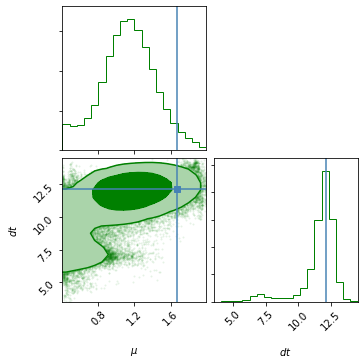

In [15]:
def contour(fit):
    #print("Expected: mu=",mu_expec, "dt=",dt_expec)
    la = fit.extract(permuted=True)
    mu_pos = np.vstack((la['mu'])).T
    dt_pos = np.vstack((la['dt'])).T
    #print(mu_pos.shape)
    #P_pos=np.vstack((la['P'])).T
    postsamples = np.vstack((mu_pos, dt_pos)).T
    #print(postsamples.shape)
    fig = corner.corner(postsamples, labels=[r"$\mu$", r"$dt$"],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=1,
                           truths=list([mu_des,dt_des]))
    #return fig
    
contour(fit3)

template 1+ stretch+ crossing stat upto 4th order

In [12]:
model = """
functions{
    vector crossing_model(vector xx, real xm, real t0, int Nx, real mean,real sig, real s, 
    real c0,real c1,real c2,real c3,real c4)
    {
        
        vector[Nx] fx;
        vector[Nx] fx_mod;
        real xs;
        real x;
        int j;

      // /* j=1;
      //  while(xx[j]<=t0)
      //  {
      //      fx[j]=0;
      //      fx_mod[j]=0;
      //      j=j+1;
      //  
      //  }*/

        
        for (i in 1:Nx)
        {
            x=xx[i]-t0; xs=x/(xm-t0);
            if(x<=0)
            {
                fx[i]=0;
                fx_mod[i]=0;
            }
            else
            {
                fx[i]=(1.0/(sig*sqrt(2.0*pi())*x))*exp(-0.5*(log(x)-mean)*(log(x)-mean)/(sig*sig));
                fx_mod[i]=fx[i]*(c0+c1*xs+c2*(2.0*xs*xs -1.0)
                +c3*(4.0*xs*xs*xs-3.0*xs)+c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
            }
        }
        
        
    
        return fx_mod;
    
    }


    
    //==============================================================================
}

data{

    int<lower=0> ni;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;
    int<lower=0> Nz;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;
    real trm;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;
    real tgm;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;
    real tim;
    
    vector[Nz] tz;
    vector[Nz] yz;
    vector[Nz] yz_error;
    real tzm;
    
    real dt_max;
}
parameters {

    real<lower=0.0, upper=10.0> meanr; real<lower=0.0, upper=3.0> sigr; real<lower=0.0,upper=0.99> sr;
    real<lower=0.0, upper=10.0> meang; real<lower=0.0, upper=3.0> sigg; real<lower=0.0,upper=0.99> sg;
    real<lower=0.0, upper=10.0> meani; real<lower=0.0, upper=3.0> sigi; real<lower=0.0,upper=0.99> si;
    real<lower=0.0, upper=10.0> meanz; real<lower=0.0, upper=3.0> sigz; real<lower=0.0,upper=0.99> sz;
    
    real c0r; real c1r; real c2r; real c3r; real c4r;
    real c0g; real c1g; real c2g; real c3g; real c4g;
    real c0i; real c1i; real c2i; real c3i; real c4i;
    real c0z; real c1z; real c2z; real c3z; real c4z;
    
    real<lower=0.4, upper=2.5> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    real<lower=0.0, upper=60.0> t0;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;
    vector[Nz] dumz;

    //dum needs
    dumr=crossing_model(tr, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r,c3r,c4r);
    dumr=dumr+mu*crossing_model(tr-dt, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r,c3r,c4r);//adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=crossing_model(tg, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g,c3g,c4g);
    dumg=dumg+mu*crossing_model(tg-dt, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g,c3g,c4g);//adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=crossing_model(ti, tim, t0, Ni,meani,sigi,si, c0i,c1i,c2i,c3i,c4i);
    dumi=dumi+mu*crossing_model(ti-dt, tim, t0,Ni,meani,sigi,si,c0i,c1i,c2i,c3i,c4i);//adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);
    
    dumz=crossing_model(tz,tzm, t0, Nz,meanz,sigz,sz, c0z,c1z,c2z,c3z,c4z);
    dumz=dumz+mu*crossing_model(tz-dt, tzm, t0,Nz,meanz,sigz,sz, c0z,c1z,c2z,c3z,c4z);//adding the 2nd image
    target+=normal_lpdf(yz|dumz,yz_error);
      

}
"""
NI=2

dt_min=0.0; dt_max=25.0

trm=np.amax(tr); tgm= np.amax(tg); tim= np.amax(ti); tzm=np.amax(tz);

data = {'ni':NI,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti), 'Nz': len(tz),
        'tr': tr, 'yr': fr, 'yr_error':sigfr, 'trm':trm,
        'tg': tg, 'yg': fg, 'yg_error':sigfg, 'tgm':tgm,
        'ti': ti, 'yi': fi, 'yi_error':sigfi, 'tim':tim,
        'tz': tz, 'yz': fz, 'yz_error':sigfz, 'tzm':tzm,
        'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit4 = sm.sampling(data=data, iter=60000, chains=6, warmup=5000, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6cb57f85bbb9c5ea6068fe2403b97eaa NOW.


Inference for Stan model: anon_model_6cb57f85bbb9c5ea6068fe2403b97eaa.
6 chains, each with iter=60000; warmup=5000; thin=3; 
post-warmup draws per chain=18334, total post-warmup draws=110004.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
meanr   3.42    0.09   0.28   2.95   3.16   3.43   3.63   3.97     10   1.68
sigr    0.61    0.15   0.27   0.35   0.45   0.51   0.58    1.2      3   5.66
sr       0.5    0.02   0.27   0.03    0.3   0.45   0.72   0.98    260   1.02
meang   2.89    0.11   0.32   2.25   2.67   2.87    3.1   3.55      9   1.53
sigg    0.52    0.14   0.25   0.26   0.36   0.43   0.53   1.04      3   4.76
sg       0.5    0.02   0.26   0.04   0.31   0.42   0.71   0.97    242   1.02
meani   3.04    0.29   0.62   1.98   2.54   3.18   3.42   4.02      4   1.95
sigi    0.79    0.27   0.54   0.38   0.51   0.59   0.74   2.75      4   2.84
si      0.43    0.08    0.3   0.02   0.11   0.41    0.7   0.95     14   1.19
meanz   3.04    0.34   0.64   2.04   

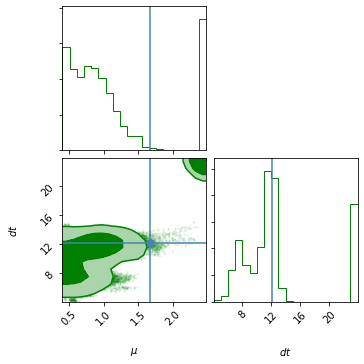

In [16]:
contour(fit4)

The desired result is quite far from 68% contour